In [1]:
import os 
os.chdir('D:\DSC672_PAC\Final_Project\Processed Files_LATEST\Processed Files\Concatenated Files')
#os.chdir('C:\\Users\\htran12\\Downloads')

In [2]:
from math import sqrt

#numpy 
import numpy as np
from numpy import concatenate

#pandas
import pandas as pd
from pandas import to_datetime
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

#matplotlib
from matplotlib import pyplot

#seaborn
import seaborn as sns

#scipy
from scipy import stats

#sklearn
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
#keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Embedding
from keras.layers import LSTM, GRU

Using TensorFlow backend.


In [4]:
#import data sets
cons = read_csv('consumption_powercity_concat_w_cal_new.csv', index_col=0)
sola_prod = read_csv('production_solararray_concat.csv', index_col=0)
wind_prod = read_csv('production_windfarm_concat.csv', index_col=0)
scen = read_csv('scenario_powercity_concat_w_cal.csv', index_col=0)
sect = read_csv('sector_sizes.csv', index_col=0)

### consumption

In [6]:
#manually specify column names
cons.index.name = 'date'
cons.columns = ['Mt','Dt','Ht','Dow','Wkdy','Hd','Sd','Sect','ECons',
                'SEle','CCov','DPnt','HFra','PWat','Temp','Vis']

In [7]:
print(cons.head(3))

               Mt  Dt  Ht  Dow Wkdy    Hd    Sd          Sect     ECons  \
date                                                                      
1/1/1991 0:00   1   1   0    1  Sun  hd_1  sd_0  FOOD_SERVICE  0.005416   
1/1/1991 0:00   1   1   0    1  Sun  hd_1  sd_0       GROCERY  0.002030   
1/1/1991 0:00   1   1   0    1  Sun  hd_1  sd_0   HEALTH_CARE  0.002390   

                    SEle  CCov  DPnt  HFra  PWat  Temp  Vis  
date                                                         
1/1/1991 0:00 -68.532769   1.0  -8.9  0.81     6  -6.1  4.0  
1/1/1991 0:00 -68.532769   1.0  -8.9  0.81     6  -6.1  4.0  
1/1/1991 0:00 -68.532769   1.0  -8.9  0.81     6  -6.1  4.0  


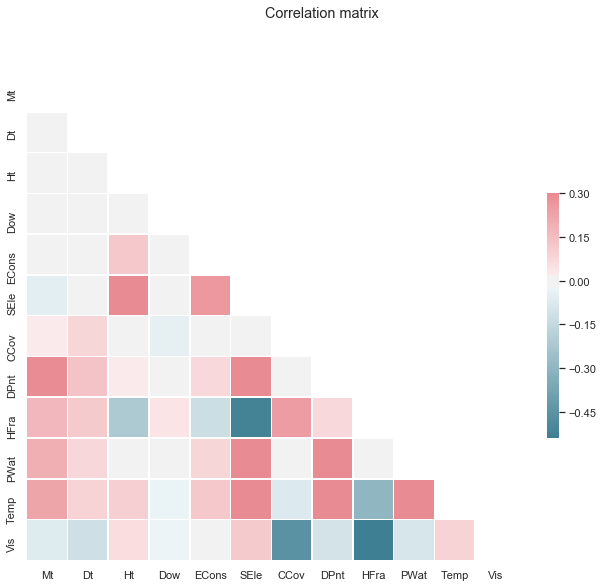

In [8]:
sns.set(style="white")

# Compute the correlation matrix
corr = cons.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = pyplot.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
pyplot.suptitle('Correlation matrix')
pyplot.savefig("corr_matrix.pdf", bbox_inches='tight')

In [9]:
#saving categorical features into their own individual for future use if needed
cons_Wkdy = cons['Wkdy']
cons_Hd = cons['Hd']
cons_Sd = cons['Sd']
cons_Sect = cons['Sect']

In [10]:
#excluding Month/Day/Hour variables
cons1 = cons.drop(columns=['Mt','Dt','Ht','Dow'])

In [11]:
cons1[:2]

,Wkdy,Hd,Sd,Sect,ECons,SEle,CCov,DPnt,HFra,PWat,Temp,Vis
date,,,,,,,,,,,,
1/1/1991 0:00,Sun,hd_1,sd_0,FOOD_SERVICE,0.005416,-68.532769,1.0,-8.9,0.81,6,-6.1,4.0
1/1/1991 0:00,Sun,hd_1,sd_0,GROCERY,0.002030,-68.532769,1.0,-8.9,0.81,6,-6.1,4.0


In [12]:
#creating binary dummy variables for categorical variables
Wkdy_dummies = pd.get_dummies(cons1.Wkdy)
Wkdy_dummies[:2]

,Fri,Mon,Sat,Sun,Thu,Tue,Wed
date,,,,,,,
1/1/1991 0:00,0,0,0,1,0,0,0
1/1/1991 0:00,0,0,0,1,0,0,0


In [13]:
Hd_dummies = pd.get_dummies(cons1.Hd)
Hd_dummies[:2]

,hd_0,hd_1
date,,
1/1/1991 0:00,0,1
1/1/1991 0:00,0,1


In [14]:
Sd_dummies = pd.get_dummies(cons1.Sd)
Sd_dummies[:2]

,sd_0,sd_1
date,,
1/1/1991 0:00,1,0
1/1/1991 0:00,1,0


In [15]:
Sect_dummies = pd.get_dummies(cons1.Sect)
Sect_dummies[:2]

,FOOD_SERVICE,GROCERY,HEALTH_CARE,K12_SCHOOLS,LODGING,OFFICE,RESIDENTIAL,STAND_ALONE_RETAIL
date,,,,,,,,
1/1/1991 0:00,1,0,0,0,0,0,0,0
1/1/1991 0:00,0,1,0,0,0,0,0,0


In [16]:
#concatinating the hotendcoded variables to the dataframe
cons1_concat = pd.concat([cons1,Wkdy_dummies,Hd_dummies,Sd_dummies,Sect_dummies], axis='columns') 
cons1_concat[:3]

,Wkdy,Hd,Sd,Sect,ECons,SEle,CCov,DPnt,HFra,PWat,...,sd_0,sd_1,FOOD_SERVICE,GROCERY,HEALTH_CARE,K12_SCHOOLS,LODGING,OFFICE,RESIDENTIAL,STAND_ALONE_RETAIL
date,,,,,,,,,,,,,,,,,,,,,
1/1/1991 0:00,Sun,hd_1,sd_0,FOOD_SERVICE,0.005416,-68.532769,1.0,-8.9,0.81,6,...,1,0,1,0,0,0,0,0,0,0
1/1/1991 0:00,Sun,hd_1,sd_0,GROCERY,0.002030,-68.532769,1.0,-8.9,0.81,6,...,1,0,0,1,0,0,0,0,0,0
1/1/1991 0:00,Sun,hd_1,sd_0,HEALTH_CARE,0.002390,-68.532769,1.0,-8.9,0.81,6,...,1,0,0,0,1,0,0,0,0,0


In [17]:
#drop the origial variables that have been hotendcoded 
cons1_concat1 = cons1_concat.drop(columns=['Wkdy','Hd','Sd','Sect'])
cons1_concat1[:3]

,ECons,SEle,CCov,DPnt,HFra,PWat,Temp,Vis,Fri,Mon,...,sd_0,sd_1,FOOD_SERVICE,GROCERY,HEALTH_CARE,K12_SCHOOLS,LODGING,OFFICE,RESIDENTIAL,STAND_ALONE_RETAIL
date,,,,,,,,,,,,,,,,,,,,,
1/1/1991 0:00,0.005416,-68.532769,1.0,-8.9,0.81,6,-6.1,4.0,0,0,...,1,0,1,0,0,0,0,0,0,0
1/1/1991 0:00,0.002030,-68.532769,1.0,-8.9,0.81,6,-6.1,4.0,0,0,...,1,0,0,1,0,0,0,0,0,0
1/1/1991 0:00,0.002390,-68.532769,1.0,-8.9,0.81,6,-6.1,4.0,0,0,...,1,0,0,0,1,0,0,0,0,0


In [18]:
ECons = cons1_concat1['ECons']
len(ECons)

70072

In [19]:
#move ECons to the last column of the dataframe 
cols = list(cons1_concat1.columns.values) 
cols.pop(cols.index('ECons')) 
cons1_concat1 = cons1_concat1[cols+['ECons']]

In [20]:
cons1_concat1[:3]

,SEle,CCov,DPnt,HFra,PWat,Temp,Vis,Fri,Mon,Sat,...,sd_1,FOOD_SERVICE,GROCERY,HEALTH_CARE,K12_SCHOOLS,LODGING,OFFICE,RESIDENTIAL,STAND_ALONE_RETAIL,ECons
date,,,,,,,,,,,,,,,,,,,,,
1/1/1991 0:00,-68.532769,1.0,-8.9,0.81,6,-6.1,4.0,0,0,0,...,0,1,0,0,0,0,0,0,0,0.005416
1/1/1991 0:00,-68.532769,1.0,-8.9,0.81,6,-6.1,4.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0.002030
1/1/1991 0:00,-68.532769,1.0,-8.9,0.81,6,-6.1,4.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0.002390


In [21]:
#function to convert time-series data to supervised learning dataframes 
#this function code is borrowed from this sorce:
#https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [22]:
#ensure all data is float
cons1_concat1 = cons1_concat1.astype('float32')

In [23]:
#control switches:
ft_norm = 1            # switch for feature normalization: 0=MinMax, 1=Standard(Z-value)

In [24]:
#normalize features BEFORE separate input and output of train/validation set
if ft_norm == 0:
    min_econs = ECons.min()
    max_econs = ECons.max()
    scaler = MinMaxScaler(feature_range=(0, 1))
    cons_normalized = scaler.fit_transform(cons1_concat1)
    print('Min Electricity consumed:', min_econs)
    print('Max Electricity consumed:', max_econs)
    print('MinMax Normalization Applied')
    
if ft_norm == 1:
    scaler = StandardScaler()
    cons_normalized = scaler.fit_transform(cons1_concat1)
    print('Standard Normalization Applied')

Standard Normalization Applied


C:\Users\ht389\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\ht389\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [25]:
#using series_to_supervised(), frame as supervised learning, with 24-hour timesteps
cons_reframed = series_to_supervised(cons_normalized, 24, 1)

In [26]:
#check shape of reframed data
cons_reframed.shape

(70048, 675)

In [27]:
cons_reframed[:3]

,var1(t-24),var2(t-24),var3(t-24),var4(t-24),var5(t-24),var6(t-24),var7(t-24),var8(t-24),var9(t-24),var10(t-24),...,var18(t),var19(t),var20(t),var21(t),var22(t),var23(t),var24(t),var25(t),var26(t),var27(t)
24,-1.980616,0.889198,-1.210853,0.331684,-1.105272,-1.282816,-1.500709,-0.407623,-0.407623,-0.407623,...,-0.933585,2.645751,-0.377964,-0.377964,-0.377964,-0.377964,-0.377964,-0.377964,-0.377964,0.292527
25,-1.980616,0.889198,-1.210853,0.331684,-1.105272,-1.282816,-1.500709,-0.407623,-0.407623,-0.407623,...,-0.933585,-0.377964,2.645751,-0.377964,-0.377964,-0.377964,-0.377964,-0.377964,-0.377964,-0.323421
26,-1.980616,0.889198,-1.210853,0.331684,-1.105272,-1.282816,-1.500709,-0.407623,-0.407623,-0.407623,...,-0.933585,-0.377964,-0.377964,2.645751,-0.377964,-0.377964,-0.377964,-0.377964,-0.377964,-0.203496


In [28]:
#for the last 27 columns (at time t), drop all except for the electricity consumption column which is column var27(t)
#var27(t) will be y target values used for training the model
cols_reframed = cons_reframed.shape[1]
cols_reframed

675

In [29]:
cols_drop = [x for x in range(cols_reframed-27,cols_reframed-1)]
print(cols_drop)
len(cols_drop)

[648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673]


26

In [30]:
cons_reframed.drop(cons_reframed.columns[cols_drop], axis=1, inplace=True)
cons_reframed[:3]

,var1(t-24),var2(t-24),var3(t-24),var4(t-24),var5(t-24),var6(t-24),var7(t-24),var8(t-24),var9(t-24),var10(t-24),...,var19(t-1),var20(t-1),var21(t-1),var22(t-1),var23(t-1),var24(t-1),var25(t-1),var26(t-1),var27(t-1),var27(t)
24,-1.980616,0.889198,-1.210853,0.331684,-1.105272,-1.282816,-1.500709,-0.407623,-0.407623,-0.407623,...,-0.377964,-0.377964,-0.377964,-0.377964,-0.377964,-0.377964,-0.377964,2.645751,-0.878846,0.292527
25,-1.980616,0.889198,-1.210853,0.331684,-1.105272,-1.282816,-1.500709,-0.407623,-0.407623,-0.407623,...,2.645751,-0.377964,-0.377964,-0.377964,-0.377964,-0.377964,-0.377964,-0.377964,0.292527,-0.323421
26,-1.980616,0.889198,-1.210853,0.331684,-1.105272,-1.282816,-1.500709,-0.407623,-0.407623,-0.407623,...,-0.377964,2.645751,-0.377964,-0.377964,-0.377964,-0.377964,-0.377964,-0.377964,-0.323421,-0.203496


In [31]:
cons_reframed.shape

(70048, 649)

In [32]:
#split reframed data into train and test sets, with train/test proportions of 75/25
cons_train, cons_test = train_test_split(cons_reframed, test_size=0.25, shuffle=False)

In [33]:
#split train data into train and validation sets, with train/validation proportions of 80/20
cons_train, cons_val = train_test_split(cons_train, test_size=0.20, shuffle=False)

In [34]:
cons_train.shape

(42028, 649)

In [35]:
cons_val.shape

(10508, 649)

In [36]:
cons_test.shape

(17512, 649)

In [37]:
#split train and validation data into input and output
train_values = cons_train.values  
val_values = cons_val.values

In [38]:
#split train and validation data into input and output
xtrain, ytrain = train_values[:, :-1], train_values[:, -1]
xval, yval = val_values[:, :-1], val_values[:, -1]

print(xtrain.shape, ytrain.shape)
print(xval.shape, yval.shape)

(42028, 648) (42028,)
(10508, 648) (10508,)


In [39]:
#get the column labels from cons_reframed for later use; there should be 649 column labels, including var27(t)
headers = list(cons_reframed.columns.values)
len(headers)

649

In [40]:
#reshape train/valid input data to be Keras-ready format [samples, timesteps, features]
xtrain = xtrain.reshape((xtrain.shape[0], 24, 27))
xval = xval.reshape((xval.shape[0], 24, 27))
print(xtrain.shape, ytrain.shape)
print(xval.shape, yval.shape)

(42028, 24, 27) (42028,)
(10508, 24, 27) (10508,)


In [41]:
#Basic Initial LSTM
!pip install keras

In [44]:
#design network 1
model = Sequential()
model.add(LSTM(50, input_shape=(xtrain.shape[1], xtrain.shape[2])))
model.add(Dense(1))

model.compile(loss='mae', optimizer='adam', metrics=['mse'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                15600     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 15,651
Trainable params: 15,651
Non-trainable params: 0
_________________________________________________________________


In [45]:
#fit network
history = model.fit(xtrain, ytrain, 
                    epochs=50,
                    batch_size=30,
                    verbose=2, 
                    shuffle=False, 
                    validation_data=(xval, yval))

Train on 42028 samples, validate on 10508 samples
Epoch 1/50
 - 13s - loss: 0.2466 - mean_squared_error: 0.1732 - val_loss: 0.1687 - val_mean_squared_error: 0.0908
Epoch 2/50
 - 12s - loss: 0.1541 - mean_squared_error: 0.0627 - val_loss: 0.1765 - val_mean_squared_error: 0.0843
Epoch 3/50
 - 14s - loss: 0.1266 - mean_squared_error: 0.0439 - val_loss: 0.1692 - val_mean_squared_error: 0.0904
Epoch 4/50
 - 14s - loss: 0.1099 - mean_squared_error: 0.0330 - val_loss: 0.1388 - val_mean_squared_error: 0.0701
Epoch 5/50
 - 14s - loss: 0.0945 - mean_squared_error: 0.0254 - val_loss: 0.1302 - val_mean_squared_error: 0.0650
Epoch 6/50
 - 14s - loss: 0.0868 - mean_squared_error: 0.0212 - val_loss: 0.1214 - val_mean_squared_error: 0.0542
Epoch 7/50
 - 14s - loss: 0.0800 - mean_squared_error: 0.0183 - val_loss: 0.1092 - val_mean_squared_error: 0.0511
Epoch 8/50
 - 14s - loss: 0.0744 - mean_squared_error: 0.0160 - val_loss: 0.1172 - val_mean_squared_error: 0.0585
Epoch 9/50
 - 14s - loss: 0.0703 - mea

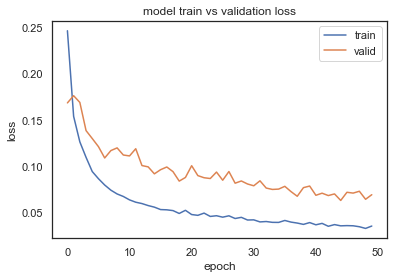

In [46]:
# plot history of loss for train and valid sets
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='valid')
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend()
pyplot.savefig("Graph1.pdf", bbox_inches='tight')
pyplot.show()

### sola_prod

In [8]:
sola_prod = sola_prod.drop(columns=['Unnamed: 0'])

In [9]:
sola_prod.index.name = 'date'
sola_prod.columns = ['Yt','Mt','Dt','Ht','ECons',
                     'SEle','CCov','DPnt','HFra','PWat',
                     'Pres','Temp','Vis','WSpe','WSpeBin']

In [10]:
print(sola_prod.head(3))

                  Yt  Mt  Dt  Ht     ECons       SEle  CCov  DPnt    HFra  \
date                                                                        
1/4/2010 15:00  2010   1   4  15  14186.16  16.551903   1.0  -8.3  0.7141   
1/4/2010 16:00  2010   1   4  16   5898.00   9.690929   1.0  -8.3  0.6827   
1/5/2010 9:00   2010   1   5   9  12421.86   6.474936   1.0  -8.3  0.8437   

                PWat   Pres  Temp     Vis  WSpe  WSpeBin  
date                                                      
1/4/2010 15:00   0.0  991.9  -3.9  16.093   5.7        4  
1/4/2010 16:00   0.0  992.2  -3.3  16.093   3.6        3  
1/5/2010 9:00    0.0  992.9  -6.1   8.047   3.1        3  


### wind_prod

In [48]:
wind_prod.index.name = 'date'
wind_prod.columns = ['Hr','Yt','Mt','Dt','ECons',
                     'WSpe','WSpeBin']

In [49]:
print(wind_prod.head(3))

                Hr    Yt  Mt  Dt  ECons  WSpe  WSpeBin
date                                                  
3/25/2011 0:00   0  2011   3  25   6476   4.9        4
3/25/2011 1:00   1  2011   3  25   3512   4.1        3
3/25/2011 2:00   2  2011   3  25   2376   3.5        3


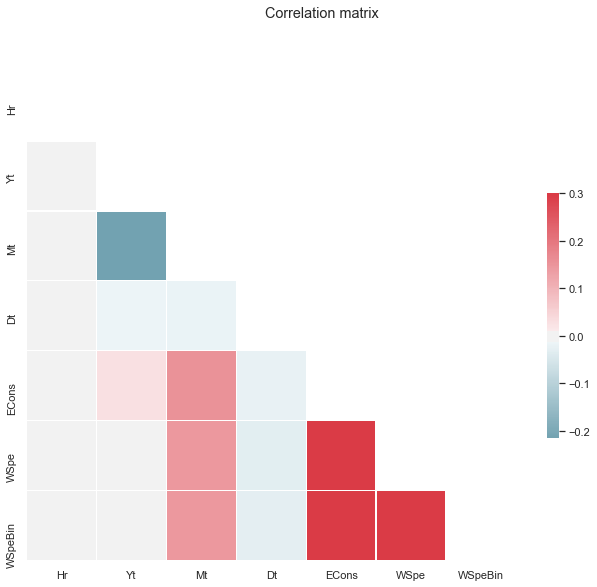

In [82]:
sns.set(style="white")

# Compute the correlation matrix
corr = wind_prod.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = pyplot.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
pyplot.suptitle('Correlation matrix')
pyplot.savefig("corr_matrix_wind.pdf", bbox_inches='tight')

In [50]:
wind_prod1 = wind_prod.drop(columns=['Hr','Yt','Mt','Dt','WSpeBin'])

In [51]:
#move ECons to the last column of the dataframe 
cols = list(wind_prod1.columns.values) 
cols.pop(cols.index('ECons')) 
wind_prod1 = wind_prod1[cols+['ECons']]

In [52]:
wind_prod1[:3]

,WSpe,ECons
date,,
3/25/2011 0:00,4.9,6476
3/25/2011 1:00,4.1,3512
3/25/2011 2:00,3.5,2376


In [54]:
len(wind_prod1)

15385

In [62]:
wind_prod1.shape

(15385, 2)

In [55]:
#using series_to_supervised(), frame as supervised learning, with 24-hour timesteps
wind_reframed = series_to_supervised(wind_prod1, 24, 1)

In [56]:
wind_reframed.shape

(15361, 50)

In [57]:
wind_reframed[:3]

,var1(t-24),var2(t-24),var1(t-23),var2(t-23),var1(t-22),var2(t-22),var1(t-21),var2(t-21),var1(t-20),var2(t-20),...,var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t),var2(t)
date,,,,,,,,,,,,,,,,,,,,,
3/26/2011 0:00,4.9,6476.0,4.1,3512.0,3.5,2376.0,3.9,3056.0,3.4,2084.0,...,3.2,1408.0,3.5,2164.0,5.0,6780.0,5.3,7792.0,4.4,4068
3/26/2011 1:00,4.1,3512.0,3.5,2376.0,3.9,3056.0,3.4,2084.0,3.3,1648.0,...,3.5,2164.0,5.0,6780.0,5.3,7792.0,4.4,4068.0,4.6,4920
3/26/2011 2:00,3.5,2376.0,3.9,3056.0,3.4,2084.0,3.3,1648.0,2.8,788.0,...,5.0,6780.0,5.3,7792.0,4.4,4068.0,4.6,4920.0,5.3,7440


In [58]:
w_cols = wind_reframed.shape[1]
w_cols

50

In [59]:
w_drop = w_cols-1
w_drop

49

In [60]:
wind_reframed.drop(wind_reframed.columns[w_drop], axis=1, inplace=True)
wind_reframed[:3]

,var1(t-24),var2(t-24),var1(t-23),var2(t-23),var1(t-22),var2(t-22),var1(t-21),var2(t-21),var1(t-20),var2(t-20),...,var2(t-5),var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t)
date,,,,,,,,,,,,,,,,,,,,,
3/26/2011 0:00,4.9,6476.0,4.1,3512.0,3.5,2376.0,3.9,3056.0,3.4,2084.0,...,2000.0,3.2,1408.0,3.5,2164.0,5.0,6780.0,5.3,7792.0,4.4
3/26/2011 1:00,4.1,3512.0,3.5,2376.0,3.9,3056.0,3.4,2084.0,3.3,1648.0,...,1408.0,3.5,2164.0,5.0,6780.0,5.3,7792.0,4.4,4068.0,4.6
3/26/2011 2:00,3.5,2376.0,3.9,3056.0,3.4,2084.0,3.3,1648.0,2.8,788.0,...,2164.0,5.0,6780.0,5.3,7792.0,4.4,4068.0,4.6,4920.0,5.3


In [61]:
wind_reframed.shape

(15361, 49)

In [70]:
# split reframed data into train and validation sets
wind_train = wind_reframed[:11700] #Mar 2011 - Jul 2012
wind_test = wind_reframed[11700:] #Aug 2012 - Dec 2012

In [71]:
w_train = wind_train[:8776] #Mar 2011 - Mar 2012
w_valid = wind_train[8776:] #Apr 2012 - Jul 2012

In [72]:
w_train.shape

(8776, 49)

In [73]:
w_valid.shape

(2924, 49)

In [74]:
wind_test.shape

(3661, 49)

In [75]:
#split train and validation data into input and output
train_values = w_train.values  
valid_values = w_valid.values

In [76]:
#split train and validation data into input and output
x_train, y_train = train_values[:, :-1], train_values[:, -1]
x_valid, y_valid = valid_values[:, :-1], valid_values[:, -1]

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(8776, 48) (8776,)
(2924, 48) (2924,)


In [77]:
# get the column labels from wind_reframed for later use
# there should be 49 column labels, including var2(t)
wind_headers = list(wind_reframed.columns.values)
len(wind_headers)

49

In [78]:
# Reshape train/valid input data to be Keras-ready format [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 24, 2))
x_valid = x_valid.reshape((x_valid.shape[0], 24, 2))
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(8776, 24, 2) (8776,)
(2924, 24, 2) (2924,)


In [79]:
# design neural net 1
def buildModel():
    'a funtion that builds a Neural networks model'
    w_model = Sequential()
    w_model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
    w_model.add(Dense(1))
    
    w_model.compile(loss='mae', optimizer='adam', metrics=['mse'])
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                10600     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 10,651
Trainable params: 10,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nn1 = buildModel()
nn1.summary()

In [80]:
#fit network
history = nn1.fit(x_train, y_train, 
                    epochs=50,
                    batch_size=30,
                    verbose=2, 
                    shuffle=False, 
                    validation_data=(x_valid, y_valid))

Train on 8776 samples, validate on 2924 samples
Epoch 1/50
 - 6s - loss: 3.1322 - mean_squared_error: 15.3197 - val_loss: 1.9617 - val_mean_squared_error: 6.6243
Epoch 2/50
 - 4s - loss: 2.1261 - mean_squared_error: 8.0102 - val_loss: 1.8591 - val_mean_squared_error: 5.9041
Epoch 3/50
 - 4s - loss: 2.1685 - mean_squared_error: 8.7324 - val_loss: 1.7816 - val_mean_squared_error: 5.6776
Epoch 4/50
 - 4s - loss: 2.0748 - mean_squared_error: 7.9383 - val_loss: 1.6995 - val_mean_squared_error: 5.0841
Epoch 5/50
 - 4s - loss: 1.8414 - mean_squared_error: 6.3544 - val_loss: 1.3668 - val_mean_squared_error: 3.1585
Epoch 6/50
 - 5s - loss: 1.7264 - mean_squared_error: 5.3482 - val_loss: 1.4440 - val_mean_squared_error: 3.4648
Epoch 7/50
 - 4s - loss: 1.7611 - mean_squared_error: 6.1240 - val_loss: 1.6579 - val_mean_squared_error: 4.6070
Epoch 8/50
 - 4s - loss: 1.9752 - mean_squared_error: 7.3816 - val_loss: 1.9331 - val_mean_squared_error: 6.3579
Epoch 9/50
 - 4s - loss: 1.8741 - mean_squared_

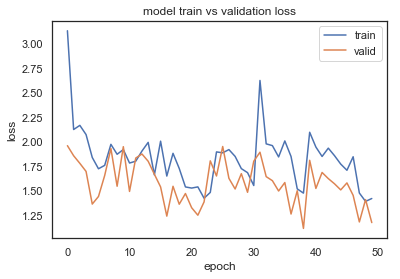

In [83]:
# plot history of loss for train and valid sets
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='valid')
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend()
pyplot.savefig("Graph2.png", bbox_inches='tight')
pyplot.show()

In [85]:
#use z-score to detect outliers
wind_z = np.abs(stats.zscore(wind_prod1))
print(wind_z)

[[0.35682169 0.44535555]
 [0.67437493 0.68237431]
 [0.91253986 0.77321551]
 ...
 [2.5805458  3.22507663]
 [2.42176918 3.13775393]
 [2.46146334 3.08273743]]


In [86]:
threshold = 3
print(np.where(wind_z > 3))

(array([ 3505,  3505,  3853,  3861,  3861,  3994,  3995,  3997,  4571,
        4670,  5014,  5015,  5016,  5252,  5253,  5254,  5254,  5255,
        5255,  5256,  5258,  5811,  5812,  5813,  5814,  5815,  5816,
        5875,  5910,  5911,  5924,  5925,  5929,  5929,  5930,  5931,
        5955,  5956,  5957,  5958,  5958,  5959,  5959,  5960,  5960,
        5961,  5961,  5962,  5962,  5963,  5964,  6056,  6060,  6061,
        6061,  6062,  6063,  6069,  6086,  6087,  6087,  6088,  6088,
        6089,  6089,  6090,  6090,  6091,  6091,  6092,  6092,  6093,
        6093,  6094,  6094,  6095,  6095,  6096,  6096,  6097,  6097,
        6098,  6098,  6189,  6190,  6191,  6191,  6192,  6192,  6193,
        6193,  6194,  6194,  6195,  6195,  6196,  6196,  6197,  6197,
        6198,  6198,  6199,  6199,  6200,  6200,  6201,  6201,  6202,
        6202,  6223,  6223,  6240,  6241,  6242,  6247,  6250,  6250,
        6251,  6251,  6267,  6270,  6270,  6271,  6271,  6272,  6272,
        6273,  6273

In [88]:
#wind data with outliers removed
wind_prod2 = wind_prod1[(wind_z < 3).all(axis=1)]

In [89]:
wind_prod2.shape

(15150, 2)

In [107]:
wind_prod2[:3]

,WSpe,ECons
date,,
3/25/2011 0:00,4.9,6476
3/25/2011 1:00,4.1,3512
3/25/2011 2:00,3.5,2376


In [108]:
x = wind_prod2['WSpe'].values
y = wind_prod2['ECons'].values

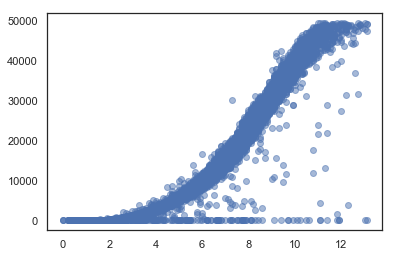

In [111]:
pyplot.scatter(x, y, alpha=0.5)
pyplot.show()

In [90]:
#using series_to_supervised(), frame as supervised learning, with 24-hour timesteps
wind_reframed2 = series_to_supervised(wind_prod2, 24, 1)

In [91]:
w_cols = wind_reframed2.shape[1]
w_drop = w_cols-1

In [92]:
wind_reframed2.drop(wind_reframed2.columns[w_drop], axis=1, inplace=True)

In [93]:
#split reframed data into train and test sets, with train/test proportions of 75/25
w_train2, w_test2 = train_test_split(wind_reframed2, test_size=0.25, shuffle=False)

In [94]:
#split train data into train and validation sets, with train/validation proportions of 80/20
w_train2, w_valid2 = train_test_split(w_train2, test_size=0.20, shuffle=False)

In [96]:
w_train2.shape

(9075, 49)

In [97]:
w_test2.shape

(3782, 49)

In [98]:
w_valid2.shape

(2269, 49)

In [99]:
#split train and validation data into input and output
train_values2 = w_train2.values  
valid_values2 = w_valid2.values

In [100]:
x_train2, y_train2 = train_values2[:, :-1], train_values2[:, -1]
x_valid2, y_valid2 = valid_values2[:, :-1], valid_values2[:, -1]

print(x_train2.shape, y_train2.shape)
print(x_valid2.shape, y_valid2.shape)

(9075, 48) (9075,)
(2269, 48) (2269,)


In [101]:
# Reshape train/valid input data to be Keras-ready format [samples, timesteps, features]
x_train2 = x_train2.reshape((x_train2.shape[0], 24, 2))
x_valid2 = x_valid2.reshape((x_valid2.shape[0], 24, 2))
print(x_train2.shape, y_train2.shape)
print(x_valid2.shape, y_valid2.shape)

(9075, 24, 2) (9075,)
(2269, 24, 2) (2269,)


In [103]:
# design neural net 2
def buildModel():
    'a funtion that builds a Neural networks model'
    w_model = Sequential()
    w_model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
    w_model.add(Dense(1))
    
    w_model.compile(loss='mae', optimizer='adam', metrics=['mse'])
    return model

In [104]:
nn2 = buildModel()
nn2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                10600     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 10,651
Trainable params: 10,651
Non-trainable params: 0
_________________________________________________________________


In [105]:
#fit network
history = nn2.fit(x_train2, y_train2, 
                    epochs=50,
                    batch_size=30,
                    verbose=2, 
                    shuffle=False, 
                    validation_data=(x_valid2, y_valid2))

Train on 9075 samples, validate on 2269 samples
Epoch 1/50
 - 5s - loss: 1.2130 - mean_squared_error: 2.5553 - val_loss: 1.1319 - val_mean_squared_error: 2.2717
Epoch 2/50
 - 4s - loss: 1.4579 - mean_squared_error: 4.1650 - val_loss: 1.8713 - val_mean_squared_error: 5.7963
Epoch 3/50
 - 5s - loss: 1.5849 - mean_squared_error: 4.4056 - val_loss: 2.0862 - val_mean_squared_error: 7.0833
Epoch 4/50
 - 5s - loss: 1.9349 - mean_squared_error: 6.2089 - val_loss: 1.8150 - val_mean_squared_error: 5.2856
Epoch 5/50
 - 5s - loss: 1.9311 - mean_squared_error: 6.0949 - val_loss: 2.1167 - val_mean_squared_error: 7.0863
Epoch 6/50
 - 5s - loss: 1.9058 - mean_squared_error: 5.9686 - val_loss: 1.7017 - val_mean_squared_error: 4.6479
Epoch 7/50
 - 5s - loss: 1.7903 - mean_squared_error: 5.3559 - val_loss: 1.6957 - val_mean_squared_error: 4.7793
Epoch 8/50
 - 5s - loss: 1.6033 - mean_squared_error: 4.5202 - val_loss: 1.2684 - val_mean_squared_error: 2.8911
Epoch 9/50
 - 5s - loss: 1.8453 - mean_squared_e

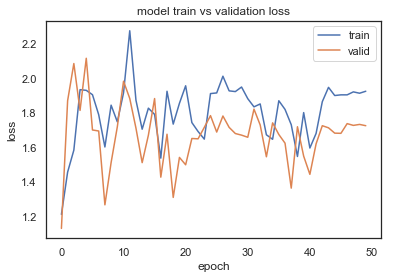

In [106]:
# plot history of loss for train and valid sets
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='valid')
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend()
pyplot.savefig("Graph3.png", bbox_inches='tight')
pyplot.show()

In [ ]:
#Reset model
model = buildModel()

### scen

In [15]:
scen = scen.drop(columns=['Consumption_type'])

In [16]:
scen.index.name = 'date'
scen.columns = ['Mt','Dt','Ht','Dow','Wkdy','Hd','Sd','ECons',
                'CCov','DPnt','HFra','PWat','Pres','Temp','Vis',
                'WSpe','WSpeBin']

In [17]:
print(scen.head(3))

               Mt  Dt  Ht  Dow Wkdy  Hd  Sd        ECons  CCov  DPnt    HFra  \
date                                                                           
1/1/1991 0:00   1   1   0    3  Tue   1   0  22597.66901   1.0  -1.7  0.9225   
1/1/1991 1:00   1   1   1    3  Tue   1   0  22597.66901   1.0  -1.7  0.9568   
1/1/1991 2:00   1   1   2    3  Tue   1   0  22597.66901   1.0  -2.8  0.8820   

               PWat   Pres  Temp    Vis  WSpe  WSpeBin  
date                                                    
1/1/1991 0:00   0.0  975.0  -0.6  2.012   5.7        4  
1/1/1991 1:00   0.3  973.9  -1.1  0.800   6.2        5  
1/1/1991 2:00   0.8  973.4  -1.1  0.805   6.2        5  


In [18]:
### sect

In [19]:
sect.columns = ['<5','5>18','18>25','25>65','65+','Total_Sqft']

In [20]:
print(sect.head(3))

                     <5        5>18      18>25      25>65        65+  \
Sector                                                                 
Food Service   0.000000    2.732693  15.485258  10.930770  10.019873   
Health Care   20.178737    2.063909   5.957220  10.589096   9.028940   
K-12           0.000000  140.000000   0.000000   0.000000   0.000000   

                Total_Sqft  
Sector                      
Food Service  9.675581e+05  
Health Care   9.653743e+05  
K-12          2.426480e+06  
